# Set Up

In [2]:
# Install module needed for the project
!pip install geoalchemy2
!pip install geopandas
!pip install psycopg2-binary

In [2]:
# Import statements needed for the project
import json
import pathlib
import urllib.parse
import os
import pyproj

import geoalchemy2 as gdb
from geoalchemy2 import Geometry, WKTElement
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import pandas as pd
import requests
import shapely
from shapely import wkb
import sqlalchemy as db

from sqlalchemy.orm import declarative_base
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, Column, String, Integer, Date, Float, MetaData, Table, create_engine, text
import psycopg2
from shapely.geometry import Point
import seaborn as sns

# Part 1: Data Preprocessing

## 1.1) NYC Open Data

In [2]:
## Store URL and application token
url_complaint = "https://data.cityofnewyork.us/resource/erm2-nwe9.geojson"
url_tree = "https://data.cityofnewyork.us/resource/5rq2-4hqu.geojson"
app_token = "YgXUUmVq41Z9433qxe5qpLOMG"

## Define date time range
start_date = "2022-10-01"
end_date = "2023-09-30"

## Define parameter
params_complaint = {"$$app_token": app_token,
                    "$select": "incident_zip,created_date,location,complaint_type",
                    "$where": f"created_date between '{start_date}T00:00:00' and '{end_date}T23:59:59'",
                    "$limit": 35_000_000}

params_tree = {"$$app_token": app_token,
               "$select": "zipcode,created_at, the_geom, spc_common,health,status",
               "$limit": 690_000}

## Import NYC Open Data
raw_data_complaint = requests.get(url_complaint, params=params_complaint).json()
raw_data_tree = requests.get(url_tree, params=params_tree).json()

## Convert JSON to DataFrame
gdf_complaint = gpd.GeoDataFrame.from_features(raw_data_complaint['features'])
gdf_tree = gpd.GeoDataFrame.from_features(raw_data_tree['features'])

In [3]:
## Set the CRS to EPSG:4326
gdf_complaint.crs = "EPSG:4326"
gdf_tree.crs = "EPSG:4326"

In [6]:
### Cleaning Data ###

## Rename columns to have consistent naming
# Rename zipcode column in complaint dataframe
gdf_complaint.rename(columns={'incident_zip': 'zipcode'}, inplace=True)
# Rename date column in complaint dataframe
gdf_complaint.rename(columns={'created_date': 'created_at'}, inplace=True)

## Convert data types
# Convert 'zipcode' data type to str in complaint and tree dataframe
gdf_complaint['zipcode'] = gdf_complaint['zipcode'].astype(str)
gdf_tree['zipcode'] = gdf_tree['zipcode'].astype(str)
# Convert 'created_at' data type to datetime in complaint dataframe
gdf_complaint['created_at'] = pd.to_datetime(gdf_complaint['created_at'])

## Add a 'complaint_id' column with unique IDs to your DataFrame
gdf_complaint['complaint_id'] = range(1, len(gdf_complaint) + 1)
# Add a 'tree_id' column with unique IDs to your DataFrame
gdf_tree['tree_id'] = range(1, len(gdf_tree) + 1)


## 1.2) Geometric boundary data 

In [17]:
### Getting Data ###

## Define the path to the SHP file (and related files)
# Path for Irene  'data', 'nyc_zipcodes.shp'
# Path for Sahaphon r'C:\Users\USER\Documents\GitHub\Tools-for-Analytic-Project\data\nyc_zipcodes.shp'
Geom_file_path = os.path.join(os.getcwd(),r'C:\Users\USER\Documents\GitHub\Tools-for-Analytic-Project\data\nyc_zipcodes.shp')

## Load the shapefile using geopandas and normalize 
gdf_zipcode = gpd.read_file(Geom_file_path).to_crs(epsg=4326)

In [18]:
### Cleaning Data ###

## Column selection
# Specify the columns to keep
columns_to_keep = ['ZIPCODE', 'geometry']
# Use the indexing operator to select the desired columns
gdf_zipcode = gdf_zipcode[columns_to_keep]

## Rename columns to have consistent naming
# Rename columns 'ZIPCODE'
gdf_zipcode.rename(columns={'ZIPCODE': 'zipcode'}, inplace=True)
# Rename columns 'geometry'
gdf_zipcode.rename(columns={'geometry': 'boundary'}, inplace=True)

## remove row with duplicate zipcode
gdf_zipcode = gdf_zipcode.drop_duplicates(subset=['zipcode'])

## Convert 'zipcode' data type to str
gdf_zipcode['zipcode'] = gdf_zipcode['zipcode'].astype(str)

## 1.3) Rent data

In [19]:
### Getting Data ###

## Define the path to the CSV file
# Path for Irene 'data', 'zillow_rent_data.csv'
# Path for Sahaphon r'C:\Users\USER\Documents\GitHub\Tools-for-Analytic-Project\data\zillow_rent_data.csv'
rent_file_path = os.path.join(os.getcwd(), r'C:\Users\USER\Documents\GitHub\Tools-for-Analytic-Project\data\zillow_rent_data.csv')

## Convert CSV to DataFrame
gdf_rent = pd.read_csv(rent_file_path)

## Column selection
# Define the columns to delete
columns_to_delete = ['SizeRank', 'RegionID', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName']
# Use the drop method to delete the specified columns
gdf_rent = gdf_rent.drop(columns=columns_to_delete)

## Rename columns to have consistent naming
# Rename columns 'RegionName'
gdf_rent.rename(columns={'RegionName': 'zipcode'}, inplace=True)

In [20]:
### Cleaning Data ###

# Convert zipcode to string
gdf_rent['zipcode'] = gdf_rent['zipcode'].astype(str)

# Reshape DataFrame from wide to long format
df_zillow = df.melt(id_vars='zipcode', var_name='date', value_name='average_rent')

# Drop rows where 'average_rent' is null
df_zillow = df_zillow.dropna(subset=['average_rent'])

# Convert 'date' to a datetime type
df_zillow['date'] = pd.to_datetime(df_zillow['date'], format='%Y-%m-%d')

## Part 2: Storing Data

## 2.1) Create Database

In [22]:
## Create a new database in PostgreSQL
#!createdb group4501project

^C


In [20]:
## Turn on the PostGIS extension
#!psql --dbname group48project -c 'CREATE EXTENSION postgis;'

ERROR:  extension "postgis" already exists


## 2.2) Create Schema File

In [23]:
## Schema for complaint data 
NYC_311_SCHEMA = """
CREATE TABLE IF NOT EXISTS complaints_311 (
    complaint_id SERIAL PRIMARY KEY,
    geometry GEOMETRY(Point),
    zipcode VARCHAR(10),
    created_at TIMESTAMP,
    complaint_type VARCHAR(50)
);
CREATE INDEX IF NOT EXISTS idx_complaints_311_geometry ON complaints_311 USING GIST (geometry);
"""

## Schema for tree data
NYC_TREE_SCHEMA = """
CREATE TABLE IF NOT EXISTS trees (
    tree_id SERIAL PRIMARY KEY,
    zipcode VARCHAR(10),
    created_at DATE,
    geometry GEOMETRY(Point),
    spc_common VARCHAR(255),
    health VARCHAR(50),
    status VARCHAR(50)
);
CREATE INDEX IF NOT EXISTS idx_trees_geometry ON trees USING GIST (geometry);
"""

## Schema for zipcode
ZIPCODE_SCHEMA = """
CREATE TABLE IF NOT EXISTS nyc_zip_codes (
    zipcode VARCHAR(10) PRIMARY KEY,
    boundary GEOMETRY(Polygon)
);
CREATE INDEX IF NOT EXISTS idx_nyc_zip_codes_boundary ON nyc_zip_codes USING GIST (boundary);
"""

## Schema for rent data
ZILLOW_SCHEMA = """
CREATE TABLE IF NOT EXISTS historical_rents (
    id SERIAL PRIMARY KEY,
    zipcode VARCHAR(10),
    date DATE,
    average_rent NUMERIC
);  
"""

## create schema file
with open('schema.sql', 'w') as file:
    file.write(ZIPCODE_SCHEMA)
    file.write('\n')
    file.write(NYC_311_SCHEMA)
    file.write('\n')
    file.write(NYC_TREE_SCHEMA)
    file.write('\n')
    file.write(ZILLOW_SCHEMA)

## 2.3) Create and populate tables in database

# create engine

In [1]:
# Database credentials
dbname = 'group4501project'
user = 'postgres'
host = 'localhost'
port = '5432'
password = 'postgres'

# Create an SQLAlchemy engine
engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}')

NameError: name 'create_engine' is not defined

# Populating Data to Table complaints_311

In [ ]:
## Complaint table

# Convert GeoDataFrame to PostGIS
gdf_complaint.to_postgis(name='complaints_311', con=engine, if_exists='replace', index=False, dtype={'geometry': Geometry('Point', srid=4326)})

# Execute the schema creation SQL for complaints_311
# Query to view the contents of the table
with engine.connect() as connection:
    connection.execute(text(NYC_311_SCHEMA))
    query = "SELECT complaint_id, ST_AsText(geometry) as geometry, zipcode, created_at FROM complaints_311;"
    result_df = pd.read_sql_query(query, connection)

# Display the first few rows of the DataFrame
print(result_df.head())

# NOT Close the engine
# engine.dispose()

In [24]:
# SQL statement to create an index
create_index_statement = text("""
    CREATE INDEX IF NOT EXISTS idx_complaints_311_geometry 
    ON complaints_311 
    USING GIST (geometry);
""")

# Execute the statement
with engine.connect() as connection:
    connection.execute(create_index_statement)

# Populating Data to Table trees

In [25]:
# Execute the schema creation SQL for trees
with engine.connect() as connection:
    connection.execute(text(NYC_TREE_SCHEMA))

# Convert GeoDataFrame to PostGIS for trees
gdf_tree['created_at'] = pd.to_datetime(gdf_tree['created_at']).dt.date
gdf_tree = gdf_tree[gdf_tree['geometry'].notnull()]

# Define the table name for trees
table_name_trees = 'trees'

# Use the known SRID since we have normalized the data
srid = 4326

# Use to_postgis to insert data into the 'trees' table
gdf_tree.to_postgis(name=table_name_trees, con=engine, if_exists='replace', index=False, dtype={'geometry': Geometry('Point', srid=srid)})

# Query to view the contents of the 'trees' table
with engine.connect() as connection:
    query_trees = text(f"SELECT tree_id, zipcode, created_at, ST_AsText(geometry) as geometry, spc_common, health, status FROM {table_name_trees};")
    result_df_trees = pd.read_sql_query(query_trees, connection)

# Display the first few rows of the DataFrame
print(result_df_trees.head())

# Not close the engine
# engine.dispose()


   tree_id zipcode  created_at                                      geometry  \
0        1   11375  2015-08-27  POINT(-73.84421521958048 40.723091773924274)   
1        2   11357  2015-09-03   POINT(-73.81867945834878 40.79411066708779)   
2        3   11211  2015-09-05  POINT(-73.93660770459083 40.717580740099116)   
3        4   11211  2015-09-05  POINT(-73.93445615919741 40.713537494833226)   
4        5   11215  2015-08-30   POINT(-73.97597938483258 40.66677775537875)   

        spc_common health status  
0        red maple   Fair  Alive  
1          pin oak   Fair  Alive  
2      honeylocust   Good  Alive  
3      honeylocust   Good  Alive  
4  American linden   Good  Alive  


In [26]:
# SQL statement to create an index on the 'trees' table
create_index_statement_for_trees = text("""
    CREATE INDEX IF NOT EXISTS idx_trees_geometry 
    ON trees 
    USING GIST (geometry);
""")

# Execute the statement to create the index
with engine.connect() as connection:
    connection.execute(create_index_statement_for_trees)

# Populating Data to Table nyc_zip_codes

In [27]:
# Set 'boundary' as the active geometry column
gdf_zipcode = gdf_zipcode.set_geometry('boundary')

# Convert GeoDataFrame to PostGIS for nyc_zip_codes
gdf_zipcode.to_postgis(name='nyc_zip_codes', con=engine, if_exists='replace', index=False, dtype={'boundary': Geometry('Polygon', srid=4326)})

# Query to view the contents of the table
with engine.connect() as connection:
    query = "SELECT zipcode, ST_AsText(boundary) as boundary FROM nyc_zip_codes;"
    result_df = pd.read_sql_query(query, connection)

# Display the first few rows of the DataFrame
print(result_df.head())

# Close the engine
engine.dispose()

  zipcode                                           boundary
0   11436  POLYGON((1038098.2518714815 188138.38000671566...
1   11213  POLYGON((1001613.7129640579 186926.4395172149,...
2   11212  POLYGON((1011174.275535807 183696.33770971,101...
3   11225  POLYGON((995908.3654508889 183617.61280155182,...
4   11218  POLYGON((991997.1134308875 176307.4958601296,9...


In [28]:
# SQL statement to create an index on the 'nyc_zip_codes' table
create_index_statement_for_zipcodes = text("""
    CREATE INDEX IF NOT EXISTS idx_nyc_zip_codes_boundary 
    ON nyc_zip_codes 
    USING GIST (boundary);
""")

# Execute the statement to create the index
with engine.connect() as connection:
    connection.execute(create_index_statement_for_zipcodes)


# Populating Data to historical_rents

In [29]:
# STORE ZILLOW DATA

with engine.connect() as connection:
    connection.execute(text(ZILLOW_SCHEMA))
    
# Insert data into the database
df_zillow.to_sql('historical_rents', con=engine, if_exists='append', index=False)

# Query to view the contents of the table
with engine.connect() as connection:
    query = "SELECT zipcode, date, average_rent FROM historical_rents;"
    result_rent = pd.read_sql_query(query, connection)

# Display the first few rows of the DataFrame
print(result_rent.head())

  zipcode       date  average_rent
0   77494 2015-01-31   1606.206406
1   77449 2015-01-31   1257.814660
2   78660 2015-01-31   1399.372678
3   77433 2015-01-31   1332.384333
4   37013 2015-01-31   1139.424798


# Q1

In [30]:
query1 = """
SELECT zipcode, COUNT(*) as complaint_count
FROM complaints_311
WHERE created_at BETWEEN '2022-10-01' AND '2023-09-30'
GROUP BY zipcode
ORDER BY complaint_count DESC;
"""
with engine.connect() as connection:
    result_query1 = pd.read_sql_query(query1, connection)

print(result_query1)  

with open('query1_descending_complaints_per_zipcode.sql', 'w') as file:
    file.write(query1)

    zipcode  complaint_count
0     11226            49347
1     10467            47358
2     10468            44081
3     11385            43944
4     10452            43880
..      ...              ...
375   11559                1
376   11580                1
377   11581                1
378   11598                1
379   07017                1

[380 rows x 2 columns]


# Q2

In [31]:
query2 = """
SELECT zipcode, COUNT(*) as total_trees
FROM trees
GROUP BY zipcode
ORDER BY total_trees DESC
LIMIT 10;
"""

result_2 = pd.read_sql_query(text(query2), engine)
print("Query 2 Result:")
print(result_2)
with open('query2_mosttrees_zipcode.sql', 'w') as file:
    file.write(query2)

Query 2 Result:
  zipcode  total_trees
0   10312        22186
1   10314        16905
2   10306        13030
3   10309        12650
4   11234        11253
5   11385        10937
6   11357         9449
7   11207         8634
8   11434         8274
9   11208         8245


# Q3

In [33]:
# SQL query to find the formatted average rent for the top 10 zip codes with the most trees in August 2023
query3 = ("""
    SELECT t.zipcode, 
           TO_CHAR(AVG(hr.average_rent), 'FM999,999,999.99') as formatted_avg_rent
    FROM trees t
    JOIN historical_rents hr ON t.zipcode = hr.zipcode
    WHERE t.zipcode IN (
        SELECT zipcode
        FROM trees
        GROUP BY zipcode
        ORDER BY COUNT(*) DESC
        LIMIT 10
    )
    AND hr.date >= '2023-08-01' AND hr.date <= '2023-08-31'
    GROUP BY t.zipcode
    ORDER BY COUNT(*) DESC;
""")

# Execute the query
with engine.connect() as connection:
    result_query3 = pd.read_sql_query(query3, connection)

# Display the result
print(result_query3)

with open('query3_mosttrees_rent.sql', 'w') as file:
    file.write(query3)
    

  zipcode formatted_avg_rent
0   10312           1,775.09
1   10314           2,465.47
2   10306           2,331.54
3   10309           1,832.01
4   11234           2,312.31
5   11385           3,064.48
6   11357           2,458.81
7   11207           3,079.09
8   11434           2,645.92
9   11208           2,737.55


# Q4

In [35]:
import pandas as pd
from sqlalchemy import create_engine

# SQL query to find the 5 zip codes with both the lowest and highest average rent in January 2023, along with their tree and complaint counts
query4 = """
    SELECT * FROM (
        SELECT
            hr.zipcode,
            AVG(hr.average_rent),
            tc.tree_count,
            cc.complaint_count,
            'Lowest' as Rent_Category
        FROM
            historical_rents hr
        INNER JOIN 
            (SELECT zipcode, COUNT(*) AS tree_count FROM trees GROUP BY zipcode) tc
        ON
            hr.zipcode = tc.zipcode
        INNER JOIN 
            (SELECT zipcode, COUNT(*) AS complaint_count FROM complaints_311 GROUP BY zipcode) cc
        ON 
            hr.zipcode = cc.zipcode
        WHERE
            hr.date >= '2023-01-01' AND hr.date <= '2023-01-31'
        GROUP BY
            hr.zipcode, tc.tree_count, cc.complaint_count
        ORDER BY
            AVG(hr.average_rent) ASC
        LIMIT 5
    ) as Lowest

    UNION ALL

    SELECT * FROM (
        SELECT
            hr.zipcode,
            AVG(hr.average_rent),
            tc.tree_count,
            cc.complaint_count,
            'Highest' as Rent_Category
        FROM
            historical_rents hr
        INNER JOIN 
            (SELECT zipcode, COUNT(*) AS tree_count FROM trees GROUP BY zipcode) tc
        ON
            hr.zipcode = tc.zipcode
        INNER JOIN 
            (SELECT zipcode, COUNT(*) AS complaint_count FROM complaints_311 GROUP BY zipcode) cc
        ON 
            hr.zipcode = cc.zipcode
        WHERE
            hr.date >= '2023-01-01' AND hr.date <= '2023-01-31'
        GROUP BY
            hr.zipcode, tc.tree_count, cc.complaint_count
        ORDER BY
            AVG(hr.average_rent) DESC
        LIMIT 5
    ) as Highest;
"""

# Execute the query and load the result into a DataFrame
with engine.connect() as connection:
    result_df = pd.read_sql(query, connection)

# Display the result
print(result_df)

with open('query4_rent_complaints_trees.sql', 'w') as file:
    file.write(query4)


  zipcode          avg  tree_count  complaint_count rent_category
0   10309  1380.514269       12650            10122        Lowest
1   10462  1801.890987        4234            30866        Lowest
2   10453  1820.234164        3050            38193        Lowest
3   11357  1829.663380        9449            12915        Lowest
4   10458  1883.075801        3405            41275        Lowest
5   10007  7270.236702         355             4199       Highest
6   10282  7143.347680         234              746       Highest
7   10013  5480.106304        1202            12488       Highest
8   10069  4959.670333         119              602       Highest
9   10011  4741.866947        2134            22282       Highest



# Q5

In [ ]:
import pandas as pd
from sqlalchemy import create_engine

    
# SQL query to find the 10 zip codes with the most trees
query5 = """
SELECT
    nz.zipcode,
    COUNT(t.tree_id) AS tree_count
FROM
    nyc_zip_codes nz
JOIN
    trees t ON ST_Intersects(ST_Transform(nz.boundary, 4326), ST_Transform(t.geometry, 4326))
GROUP BY
    nz.zipcode
ORDER BY
    tree_count DESC
LIMIT 10;


"""

# Execute the query and load the results into a DataFrame
with engine.connect() as connection:
    result_df = pd.read_sql(query5, connection)

# Display the result
print(result_df)

with open('query5_zipcode_mosttrees.sql', 'w') as file:
    file.write(query5)


# Q6

In [10]:
# Set the coordinate pair
latitude = 40.80737875669467
longitude = -73.96253174434912
search_point = Point(longitude, latitude)

# Convert the coordinate point to the same SRID as in the database (4326)
search_point_wkt = search_point.wkt

# Query to find trees within a ½ mile radius
query = """
SELECT
    tree_id AS ID,
    spc_common AS species,
    health,
    status,
    ST_AsText(geometry) AS coordinate_location
FROM
    trees
WHERE
    ST_DWithin(geometry::geography, ST_GeomFromText(:point, 4326)::geography, 804.672);
"""

# Execute the query with the search point parameter
result = pd.read_sql_query(text(query), engine, params={"point": search_point_wkt})

# Display the result
print(result)

InternalError: (psycopg2.errors.InternalError_) LWGEOM_dwithin: Operation on mixed SRID geometries (Point, 4326) != (Polygon, 0)

[SQL: 
SELECT tree_id, spc_common, health, status, ST_AsText(geometry) as location
FROM trees
WHERE ST_DWithin(geometry, 'POLYGON ((731.0374682556509 40.80737875669467, 727.1611732267694 -38.096419208601624, 715.5696189802513 -116.24033046628855, 696.374438520079 -192.8717864331475, 669.7604919272367 -267.2527842972026, 635.9840860560766 -338.66699438823343, 595.3705061591997 -406.42665882408505, 548.3108832126542 -469.87921499503994, 495.2584271108217 -528.413580098476, 436.7240620073856 -581.4660362003085, 373.2715058364307 -628.5256591468542, 305.5118414005791 -669.1392390437311, 234.0976313095482 -702.9156449148911, 159.71663344549302 -729.5295915077335, 83.08517747863417 -748.7247719679058, 4.941266220947298 -760.3163262144237, -73.96253174434908 -764.1926212433053, -152.86632970964547 -760.3163262144238, -231.01024096733232 -748.7247719679058, -307.6416969341912 -729.5295915077335, -382.02269479824633 -702.9156449148911, -453.4369048892773 -669.1392390437311, -521.1965693251286 -628.5256591468544, -584.6491254960836 -581.4660362003087, -643.1834905995198 -528.4135800984761, -696.2359467013524 -469.87921499503994, -743.2955696478981 -406.42665882408505, -783.9091495447749 -338.66699438823355, -817.6855554159349 -267.25278429720265, -844.2995020087773 -192.8717864331475, -863.4946824689496 -116.24033046628884, -875.0862367154675 -38.09641920860181, -878.9625317443491 40.80737875669457, -875.0862367154676 119.71117672199094, -863.4946824689496 197.85508797967802, -844.2995020087773 274.4865439465367, -817.6855554159349 348.8675418105919, -783.9091495447749 420.2817519016228, -743.2955696478982 488.04141633747423, -696.2359467013525 551.4939725084291, -643.18349059952 610.0283376118654, -584.649125496084 663.0807937136976, -521.1965693251288 710.1404166602435, -453.4369048892774 750.7539965571204, -382.02269479824685 784.5304024282804, -307.6416969341914 811.1443490211228, -231.0102409673327 830.3395294812951, -152.8663297096453 841.9310837278132, -73.96253174434926 845.8073787566947, 4.941266220946758 841.9310837278132, 83.08517747863414 830.3395294812951, 159.71663344549287 811.1443490211228, 234.09763130954832 784.5304024282804, 305.51184140057893 750.7539965571204, 373.2715058364304 710.1404166602439, 436.7240620073856 663.0807937136979, 495.2584271108216 610.0283376118656, 548.3108832126538 551.4939725084296, 595.3705061591997 488.0414163374744, 635.9840860560766 420.281751901623, 669.7604919272366 348.86754181059246, 696.374438520079 274.4865439465369, 715.5696189802513 197.8550879796783, 727.1611732267694 119.71117672199088, 731.0374682556509 40.80737875669467))', 805);
]
(Background on this error at: https://sqlalche.me/e/20/2j85)

In [ ]:
Session = sessionmaker(bind=engine)
session = Session()

# Define the coordinate pair
latitude = 40.80737875669467
longitude = -73.96253174434912

# Create a Shapely Point from the coordinates
point = Point(longitude, latitude)

# Define the buffer radius in meters (approximate 0.5 miles)
buffer_radius_meters = 805

# Create a circular buffer around the point
buffer_geometry = point.buffer(buffer_radius_meters)

# Convert the Shapely geometry to Well-Known Text (WKT) format
buffer_wkt = WKTElement(buffer_geometry.wkt, srid=4326)

# Query to find trees within the buffer
query_6 = f"""
SELECT tree_id, spc_common, health, status, ST_AsText(geometry) as location
FROM trees
WHERE ST_DWithin(geometry, '{buffer_wkt}', {buffer_radius_meters});
"""

# Execute the query
result_6 = pd.read_sql_query(text(query_6), engine)

# Display the result
print("Query 6 Result:")
print(result_6)

# V1

        complaint_type  total_complaints
0      Illegal Parking            457072
1  Noise - Residential            294305
2       HEAT/HOT WATER            238219


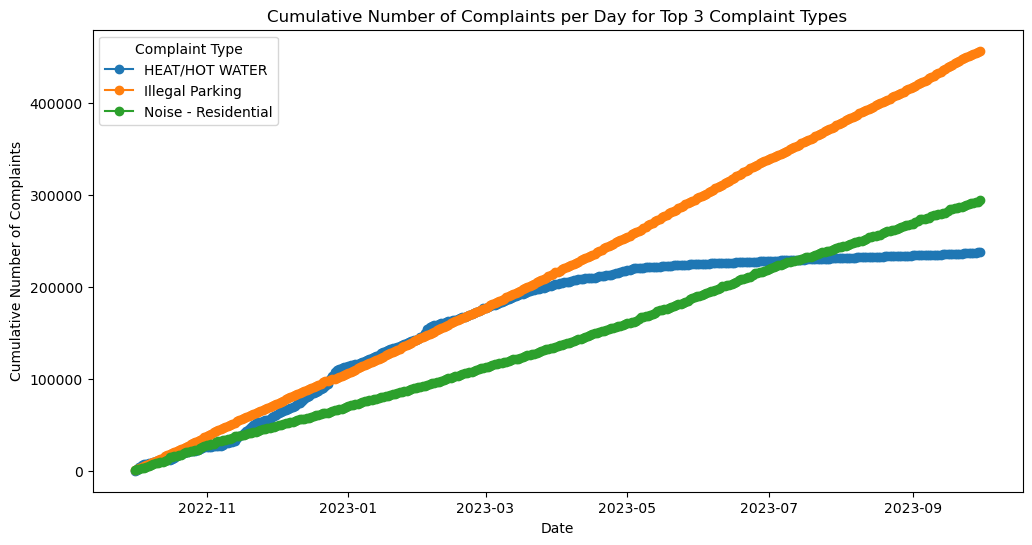

In [4]:
# Query to get the top 3 complaint types
top_complaints_query = """
SELECT
    complaint_type,
    COUNT(*) AS total_complaints
FROM
    complaints_311
WHERE
    created_at >= '2022-10-01' AND created_at < '2023-10-01'
GROUP BY
    complaint_type
ORDER BY
    total_complaints DESC
LIMIT 3
"""

# Execute the query and create a DataFrame
top_complaints = pd.read_sql(text(top_complaints_query), engine)

# Display the top 3 complaint types
print(top_complaints)

# Query to get the number of complaints per day for each complaint type
complaints_per_day_query = """
SELECT
    created_at::date AS date,
    complaint_type,
    COUNT(*) AS daily_complaints
FROM
    complaints_311
WHERE
    created_at >= '2022-10-01' AND created_at < '2023-10-01'
    AND complaint_type IN :top_complaint_types
GROUP BY
    date, complaint_type
ORDER BY
    date
"""

# Execute the query with the top complaint types
complaints_per_day = pd.read_sql(
    text(complaints_per_day_query),
    engine,
    params={'top_complaint_types': tuple(top_complaints['complaint_type'])}
)

# Pivot the DataFrame to have complaint types as columns
complaints_per_day_pivot = complaints_per_day.pivot(index='date', columns='complaint_type', values='daily_complaints')

# Compute cumulative counts for each complaint type
cumulative_counts = complaints_per_day_pivot.cumsum()

# Plot the cumulative data
plt.figure(figsize=(12, 6))
cumulative_counts.plot(ax=plt.gca(), marker='o')
plt.title('Cumulative Number of Complaints per Day for Top 3 Complaint Types')
plt.xlabel('Date')
plt.ylabel('Cumulative Number of Complaints')
plt.legend(title='Complaint Type')
plt.show()

# V2

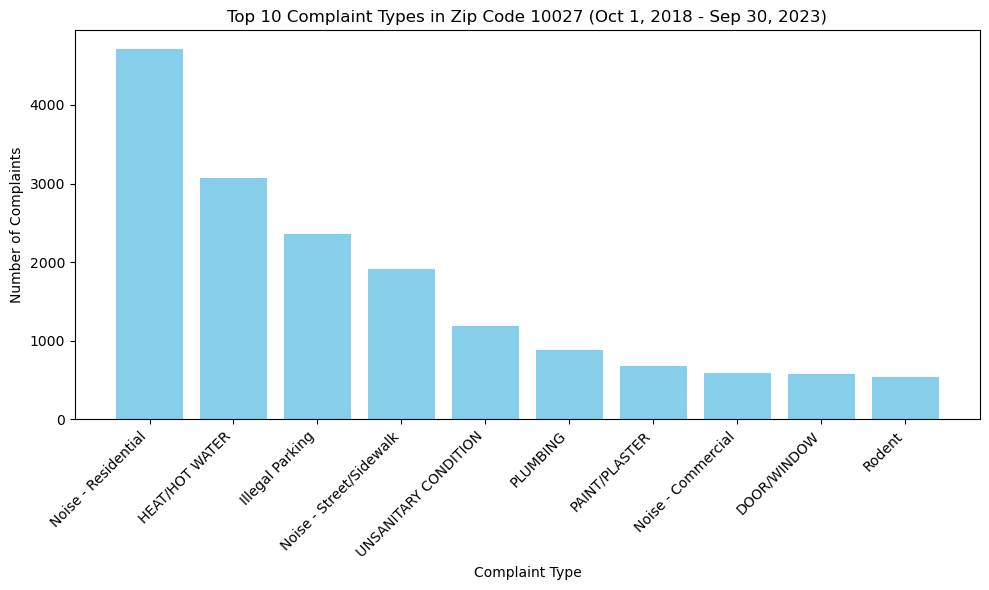

In [5]:
query = """
SELECT
    c.complaint_type,
    COUNT(c.complaint_id) AS complaint_count
FROM
    complaints_311 c
WHERE
    c.zipcode = '10027'
    AND c.created_at >= '2018-10-01' AND c.created_at < '2023-10-01'
GROUP BY
    c.complaint_type
ORDER BY
    complaint_count DESC
LIMIT 10;
"""

# Execute the query
result = pd.read_sql_query(text(query), engine)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(result['complaint_type'], result['complaint_count'], color='skyblue')
plt.xlabel('Complaint Type')
plt.ylabel('Number of Complaints')
plt.title('Top 10 Complaint Types in Zip Code 10027 (Oct 1, 2018 - Sep 30, 2023)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

# Close the engine
engine.dispose()

# V3

In [43]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt


def fetch_data():
    query = """
        SELECT
            hr.zipcode,
            AVG(hr.average_rent) AS avg_rent,
            SUM(tc.tree_count) AS total_tree_count,
            SUM(cc.complaint_count) AS total_complaint_count
        FROM
            historical_rents hr
        LEFT JOIN 
            (SELECT zipcode, COUNT(*) AS tree_count FROM trees GROUP BY zipcode) tc
        ON
            hr.zipcode = tc.zipcode
        LEFT JOIN 
            (SELECT zipcode, COUNT(*) AS complaint_count FROM complaints_311 GROUP BY zipcode) cc
        ON 
            hr.zipcode = cc.zipcode
        WHERE
            hr.date >= '2015-01-01' AND hr.date <= '2023-09-30'
        GROUP BY
            hr.zipcode;
    """
    with engine.connect() as connection:
        return pd.read_sql(query, connection)


In [44]:
def create_visualization(df):
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Rent vs Trees subplot
    ax[0].scatter(df['total_tree_count'], df['avg_rent'], color='green', alpha=0.5)
    ax[0].set_title('Average Rent vs Total Tree Count by Zip Code')
    ax[0].set_xlabel('Total Tree Count')
    ax[0].set_ylabel('Average Rent')

    # Rent vs Complaints subplot
    ax[1].scatter(df['total_complaint_count'], df['avg_rent'], color='red', alpha=0.5)
    ax[1].set_title('Average Rent vs Total Complaint Count by Zip Code')
    ax[1].set_xlabel('Total Complaint Count')
    ax[1].set_ylabel('Average Rent')

    plt.tight_layout()
    plt.show()


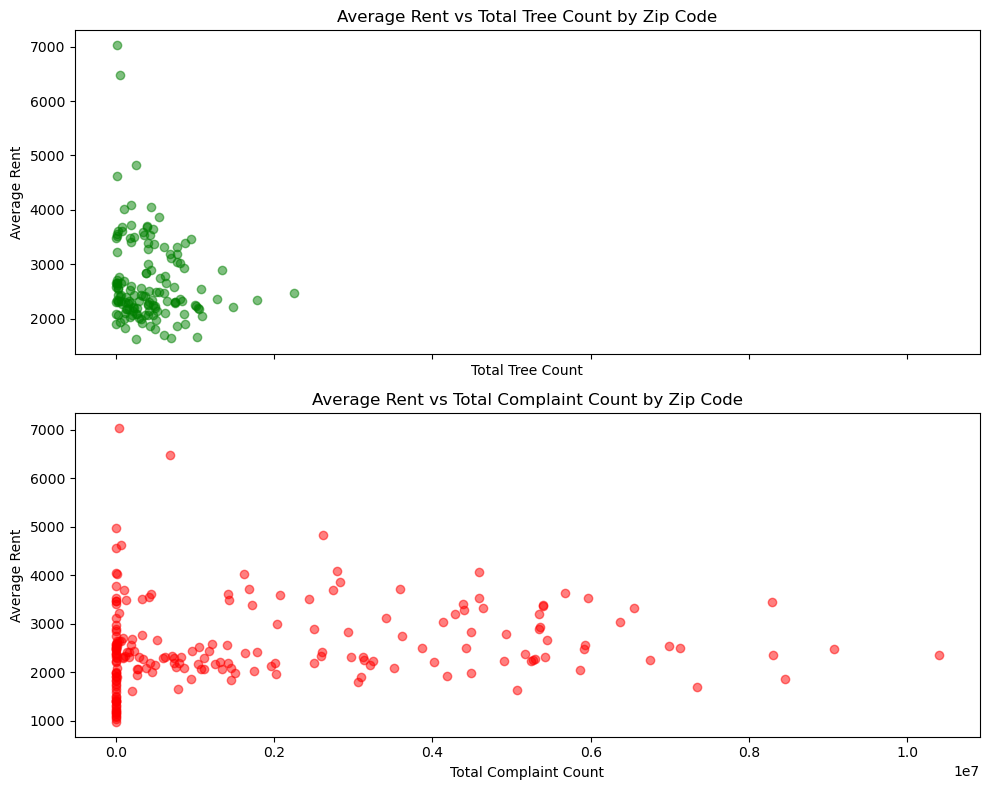

In [45]:
# Fetch data from the database
df = fetch_data()

# Create and display the visualization
create_visualization(df)


# V4

In [1]:
query = """
WITH RentComplaints AS (
    SELECT
        z.zipcode,
        AVG(hr.average_rent) AS avg_rent,
        COUNT(c.complaint_id) AS complaint_count
    FROM
        nyc_zip_codes z
        LEFT JOIN historical_rents hr ON z.zipcode = hr.zipcode
        LEFT JOIN complaints_311 c ON z.zipcode = c.zipcode
    WHERE
        hr.date >= '2023-09-01' AND hr.date < '2023-10-01'
        AND c.created_at >= '2022-10-01' AND c.created_at < '2023-10-01'
    GROUP BY
        z.zipcode
)
SELECT
    zipcode,
    AVG(avg_rent) AS avg_rent,
    SUM(complaint_count) AS total_complaints
FROM
    RentComplaints
GROUP BY
    zipcode
"""

# Execute the query
result = pd.read_sql_query(text(query), engine)

# Define the rent bins
rent_bins = list(range(0, int(result['avg_rent'].max()) + 1001, 1000))

# Create a new column for rent bins
result['rent_bin'] = pd.cut(result['avg_rent'], bins=rent_bins, right=False)

# Plotting
plt.figure(figsize=(12, 8))
sns.boxplot(x='rent_bin', y='total_complaints', data=result, palette='viridis')
plt.xlabel('Average Rent Bins')
plt.ylabel('Number of 311 Complaints')
plt.title('Relationship Between Average Rent and 311 Complaints (Oct 1, 2022 - Sep 30, 2023)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

# Close the engine
engine.dispose()

NameError: name 'pd' is not defined

# V5

In [ ]:
# Replace these coordinates with the ones from Query 6 in Part 3
target_latitude = 40.80737875669467
target_longitude = -73.96253174434912

# Set up the target point as a GeoDataFrame
target_point = gpd.GeoDataFrame(geometry=[Point(target_longitude, target_latitude)], crs='EPSG:4326')


# Query 311 incidents within a 1-kilometer radius of the target point
radius_km = 1
query = f"""
    SELECT *
    FROM complaints_311
    WHERE ST_Distance(ST_SetSRID(geometry, 4326), ST_SetSRID(ST_MakePoint({target_longitude}, {target_latitude}), 4326)) <= {radius_km * 1000};
"""

gdf_complaint_subset = gpd.read_postgis(query, con=engine, geom_col='geometry')

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
gdf_complaint_subset.plot(ax=ax, color='red', marker='o', markersize=10, label='311 Incidents')
target_point.plot(ax=ax, color='blue', marker='*', markersize=100, label='Target Location')

# Set plot properties
ax.set_title('311 Incidents within 1km Radius')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()

# Show the plot
plt.show()

# Close the database connection
engine.dispose()

# V6

In [ ]:
# Query to get tree coordinates
trees_query = """
SELECT
    tree_id,
    geometry
FROM
    trees
"""
# Execute the query and create a GeoDataFrame
trees_gdf = gpd.read_postgis(trees_query, engine, geom_col='geometry')

# Query to get "New Tree Request" 311 complaint coordinates
new_tree_request_query = """
SELECT
    complaint_id,
    geometry
FROM
    complaints_311
WHERE
    created_at BETWEEN '2018-10-01' AND '2023-09-30'
    AND complaint_type = 'New Tree Request'
"""
# Execute the query and create a GeoDataFrame
new_tree_request_gdf = gpd.read_postgis(new_tree_request_query, engine, geom_col='geometry')

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Plot trees
trees_gdf.plot(ax=ax, color='green', label='Trees')

# Plot "New Tree Request" 311 complaints
new_tree_request_gdf.plot(ax=ax, color='blue', label='New Tree Request')

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Geospatial Plot of Trees and New Tree Request Complaints')
ax.legend()

# Show the plot
plt.show()